In [164]:
import pandas as pd 
import polars as pl 

from datetime import datetime

from sklearn import base, pipeline, preprocessing
from feature_engine import encoding, imputation, outliers, transformation

from sklearn import dummy
from sklearn import tree
from sklearn import ensemble
import xgboost as xgb

import sys
import os

In [179]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# **FUNCIONES**

In [145]:
# Función para mostrar las frecuencias absolutas y relativas de un campo
def frecuencia_categoria(df,columna,orden):
    resultado = df.groupby([columna]).agg(CANTIDAD=(columna, 'count')).reset_index()
    total = resultado['CANTIDAD'].sum()
    resultado['% TOTAL'] = (resultado['CANTIDAD'] / total) * 100
    if orden == 0:
        resultado = resultado.sort_values('% TOTAL', ascending=False)
        return resultado
    elif orden == 1:
        resultado = resultado.sort_values(columna, ascending=True)
        return resultado
    else:
        return print('En orden solo puede escoger los valores 0,1')

# **CARGAR DATA**

In [146]:
RUTA_TOTAL = "C:/Users/DF357JZ/OneDrive - EY/Banco Bogota/modelo-propension-camp-as-BGG/"

In [147]:
df = pl.scan_csv(RUTA_TOTAL + "data/interim/archivo 9230_0104_EY_Proyecto_v3_clean.csv").collect()

In [148]:
lista_fecha=["FECHA_BASE","BIRTHDATE","HIRE_DT"]
lista_ID=["DEFINIT"]
lista_categoricas=[ 'CANAL_VENTA', 'MAR_STATUS',
       'NIVEL_EDUCATIVO',
       'ESTADO_CL', 'NM_SEG_CL', 'AGR_SEG', 'CIUDAD',
       'DEPARTAMENTO', 'RIESGO']
lista_numericas=[ 'AA_VLR_ING_BRU_MES', 
       'AA_VLR_PASIVOS', 'CAMPANAS_NUM', 'CL_NEW', 'SALDO_PASIVOS',
       'SALDO_ACTIVO', 'SALDO_AH_NOMINA', 'SALDO_AH_NO_NOMINA',
       'SALDO_CDT', 'SALDO_DEUDOR', 'SALDO_LIBRE_DEST',
       'SALDO_LIBRANZAS', 'SALDO_HIPOTECARIO', 'SALDO_SUT_PASIV',
       'SALDO_CUENTA', 'CUPO_CTA', 'DISPONIBLE_CTA', 'INTERES_CTE',
       'EMPLEADO', 'VALOR_DEB_NOMINA',
       'VALOR_CRED_NOMINA', 'VALOR_DEB_NO_NOM', 'VALOR_CRED_NO_NOM',
       'RENTABILIDAD', 'MARGEN_NETO', 'ATRASO_MORA', 'CANT_APERTURAS',
       'SALDO_TC_MES_ANT', 'CANT_TC_MES_ANT']
lista_numerica_score=["BB_SCORE_COMPORTA"]
var_objetivo = ['RESULTADO']
lista_drop = ['SALDO_TC','CANT_TC','ESTADO_CAMP','CAMPANAS_NUM','V_EN_CAMPANIA_MENSUAL','TIPO_APROBACION','SEX','BIN_INICIO'] # 'BIN_INICIO'
lista_vars_fix = [
    'V_EN_CAMPANIA_MENSUAL', # QUEDARME CON EL ÚLTIMO NÚMERO DE LA CAMPAÑA
    'PRODUCTOS_TC', # CREAR COLUMNA PARA CADA UNA DE ALSA TARJETAS DE MANERA INDIVIDUAL
    'ESTADO_CL', # LOS QUE TIENEN NOMBRE ID REEMPLAZARLOS POR LOS OTROS
    'TIPO_APROBACION', # FIRME VA CON FIRME FIRME
    'CIUDAD' # REDUCIR EL NUMERO DE CASOS,
    'DEPARTAMENTO', # REDUCIR EL NUMERO DE CASOS
]

# **DROP COLUMNAS**

In [149]:
df = df.drop(lista_drop)

# **FIX DATA CATEGORICA**

In [62]:
for columna in lista_categoricas:
    print('_____________________________________________________')
    print(' '+columna)
    print('\n')
    print(frecuencia_categoria(df.to_pandas(),columna,0))
    print('_____________________________________________________')
    print('\n')


_____________________________________________________
 CANAL_VENTA


   CANAL_VENTA  CANTIDAD    % TOTAL
1      DIGITAL   1233778  52.171755
3      OFICINA    558176  23.603129
5     REACTIVO    249688  10.558351
2          FMV    197023   8.331349
0  CALL CENTER    125319   5.299261
4        OTROS       855   0.036155
_____________________________________________________


_____________________________________________________
 MAR_STATUS


     MAR_STATUS  CANTIDAD    % TOTAL
4     SOLTERO/A   1527759  64.603087
0      CASADO/A    363677  15.378510
5   UNION LIBRE    212613   8.990591
2         OTROS    196957   8.328559
3    SEPARADO/A     37758   1.596641
6       VIUDO/A     20924   0.884796
1  DIVORCIADO/A      5151   0.217816
_____________________________________________________


_____________________________________________________
 NIVEL_EDUCATIVO


       NIVEL_EDUCATIVO  CANTIDAD    % TOTAL
4           SECUNDARIO   1225784  51.833719
6        UNIVERSITARIO    416324  17.60475

KeyError: 'TIPO_APROBACION'

## NUMERO DE CAMPAÑAS EN UN MES

In [152]:
df = (
    df
    .sort(['DEFINIT','FECHA_BASE'], descending=[False, False])
    .with_columns(pl.col('HIRE_DT').over(['DEFINIT','FECHA_BASE'], mapping_strategy='join').list.len().alias('VECES_MES_CAMP'))
)

## FILTRAR TODAS AQUELLAS OBSERVACIONES QUE TIENEN VALORES REPETIDOS

In [153]:
df = (
    df
    .sort(['DEFINIT','FECHA_BASE','ESTADO_CL'], descending=[True,True,True])
    .unique(['DEFINIT','FECHA_BASE'], keep='last')
)

## NUMERO DE CAMPAÑAS

In [154]:
df = (
    df
    .with_columns(pl.lit(1).alias('NUM_CAMP'))
    .with_columns(pl.col('NUM_CAMP').cum_sum().over(['DEFINIT']).alias('NUM_CAMP'))

)

## DEPARTAMENTOS Y CIUDAD (NO VA)

In [10]:
#df = (
#    df
#    .with_columns(pl.col('DEPARTAMENTO').str.strip_chars())
#    .with_columns(pl.col('CIUDAD').str.strip_chars())
#)
#     
##.get_column('DEPARTAMENTO').unique().to_list() CIUDAD

In [11]:
#lista_ciudades_significativas = pl.from_pandas(frecuencia_categoria(df.to_pandas(),'CIUDAD',0)).filter(pl.col('CANTIDAD')> 500)
#lista_departamentos_significativas = pl.from_pandas(frecuencia_categoria(df.to_pandas(),'DEPARTAMENTO',0)).filter(pl.col('CANTIDAD')> 1000).get_column('DEPARTAMENTO').to_list()

In [8]:
#df = (
#    df
#    .with_columns(
#        pl.when(pl.col('DEPARTAMENTO').is_in(lista_departamentos_significativas))
#        .then(pl.col('DEPARTAMENTO'))
#        .otherwise(pl.lit('OTROS'))
#    )
#)

In [9]:
#(
#    df
#    .with_columns(pl.lit(1).alias('% DEPARTAMENTO'))
#    .with_columns(
#        pl.col('% DEPARTAMENTO').over(['DEPARTAMENTO'], mapping_strategy='join').list.sum()/pl.col('% DEPARTAMENTO').sum()
#        )
#)

## VARIABLE ESTADO CLIENTE

In [155]:
df = (
    df
    .with_columns(
        pl.when(
            pl.col('ESTADO_CL').is_in(['ActivaSEG','Activo','ActivaFID'])
        )
        .then(pl.lit('Activo'))
        .when(pl.col('ESTADO_CL').is_in(['InactivaFID','Inactivo','Cerrado']))
        .then(pl.lit('Inactivo/Cerrado'))
        .otherwise(pl.lit('OTROS'))
        .alias('ESTADO_CL')
    )
)

## TARJETA DE CREDITO

In [156]:
lista_tarjetas = []

for card_list in all_cards:
    for card in str(card_list).split(';'):
        lista_tarjetas.append(card)

lista_tarjetas = list(set(lista_tarjetas))

In [157]:
df = (
    df
    .with_columns(
        [
            pl.when(pl.col('PRODUCTOS_TC').str.contains(card)).then(pl.lit(1)).otherwise(pl.lit(0)).alias('tc_'+card)

            for card in lista_tarjetas
        ]
    )
    #.select('OTROS')
    #.describe()
)

In [158]:
df = df.drop('PRODUCTOS_TC')

## Variables fecha 

In [160]:
df = (
    df
    
    .with_columns(pl.col('BIRTHDATE').replace('OTROS',None))
    .with_columns((pl.col('BIRTHDATE').str.split('/').list.get(0)+'-'+pl.col('BIRTHDATE').str.split('/').list.get(1)+'-'+pl.col('BIRTHDATE').str.split('/').list.get(2)).alias('BIRTHDATE'))
    .with_columns(pl.col('BIRTHDATE').str.to_date())

    .with_columns(pl.col('HIRE_DT').replace('OTROS',None))
    .with_columns((pl.col('HIRE_DT').str.split('/').list.get(0)+'-'+pl.col('HIRE_DT').str.split('/').list.get(1)+'-'+pl.col('HIRE_DT').str.split('/').list.get(2)).alias('HIRE_DT'))
    .with_columns(pl.col('HIRE_DT').str.to_date())

    .with_columns(pl.lit('2024-07-01').cast(pl.Date).alias('FECHA_HOY')) # ! FECHA DE HOY ES MANUAL

    #.with_columns(((datetime(2024,7,1) - pl.col('BIRTHDATE')).cast(int)/(1000*60*60*24)).round().cast(int).alias('EDAD')) 
    .with_columns((pl.col('FECHA_HOY').dt.year() - pl.col('BIRTHDATE').dt.year()).alias('EDAD'))
    .with_columns(((pl.col('FECHA_HOY').dt.year()*12 + (pl.col('FECHA_HOY').dt.month()) - (pl.col('HIRE_DT').dt.year()*12 + pl.col('HIRE_DT').dt.month())).alias('ANTIGUEDAD_MESES')))

    .drop(['BIRTHDATE','HIRE_DT','FECHA_HOY'])
)

## Fix BB_SCORE_COMPORTA

In [162]:
df = (
    df
    #.filter(pl.col('BB_SCORE_COMPORTA')=='OTROS')
    .with_columns(pl.when(pl.col('BB_SCORE_COMPORTA')=='OTROS').then(pl.lit('0')).otherwise(pl.col('BB_SCORE_COMPORTA')).cast(pl.Float64).alias('BB_SCORE_COMPORTA'))
)

# EDA

In [175]:
module_path = os.path.abspath(os.path.join('.')) + 'modelo_propension\modelling'
if module_path not in sys.path:
    sys.path.append(module_path)

['c:\\Users\\DF357JZ\\OneDrive - EY\\Banco Bogota\\modelo-propension-camp-as-BGG\\notebooks',
 'c:\\Users\\DF357JZ\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip',
 'c:\\Users\\DF357JZ\\AppData\\Local\\Programs\\Python\\Python311\\DLLs',
 'c:\\Users\\DF357JZ\\AppData\\Local\\Programs\\Python\\Python311\\Lib',
 'c:\\Users\\DF357JZ\\AppData\\Local\\Programs\\Python\\Python311',
 '',
 'C:\\Users\\DF357JZ\\AppData\\Roaming\\Python\\Python311\\site-packages',
 'C:\\Users\\DF357JZ\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32',
 'C:\\Users\\DF357JZ\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib',
 'C:\\Users\\DF357JZ\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin',
 'c:\\Users\\DF357JZ\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages']

In [181]:
from modelo_propension.funciones_apoyo import main

C:\Users\DF357JZ\AppData\Local\Temp\ipykernel_16736\3664280994.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)


Preprocessing completed.


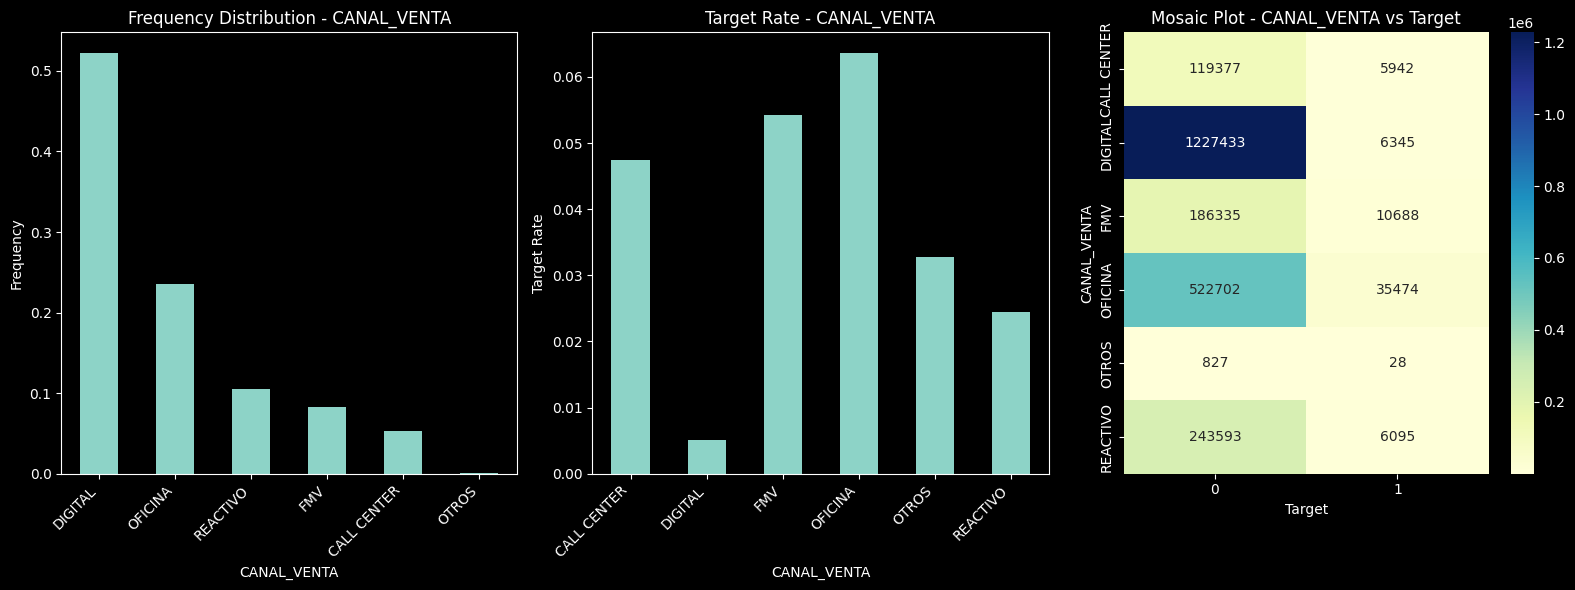

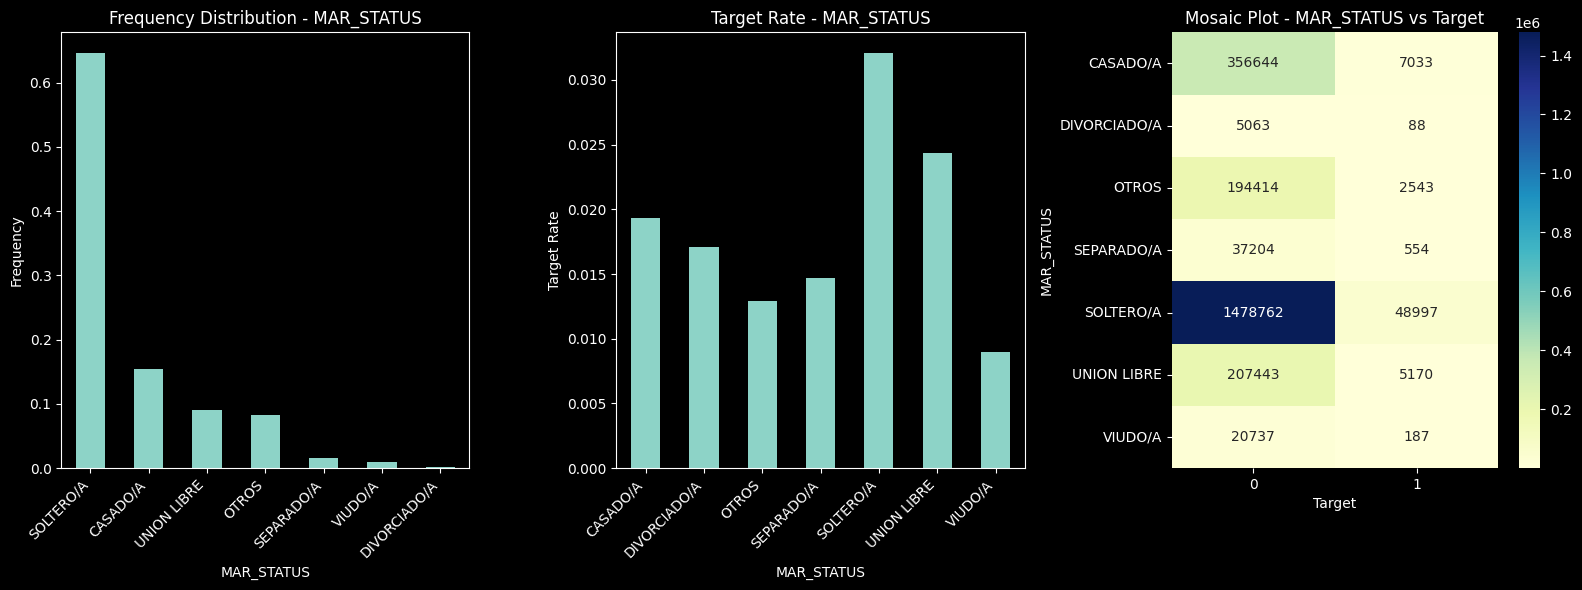

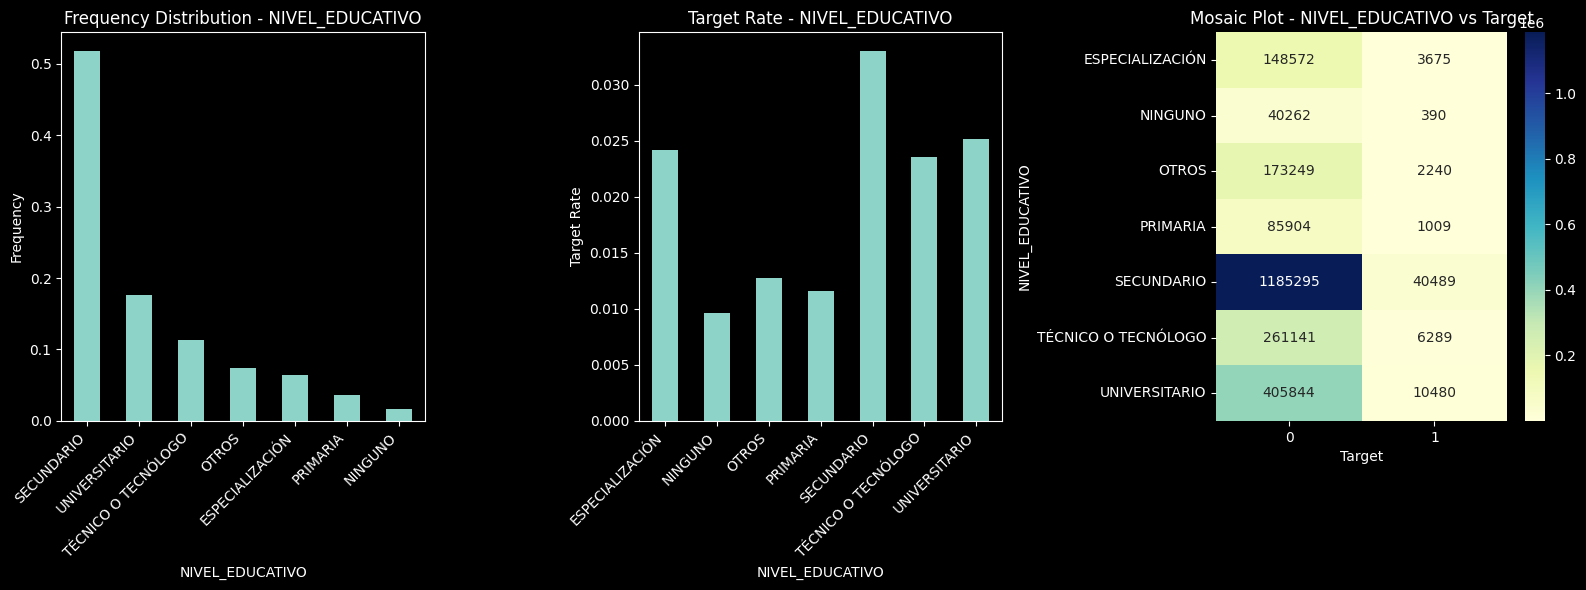

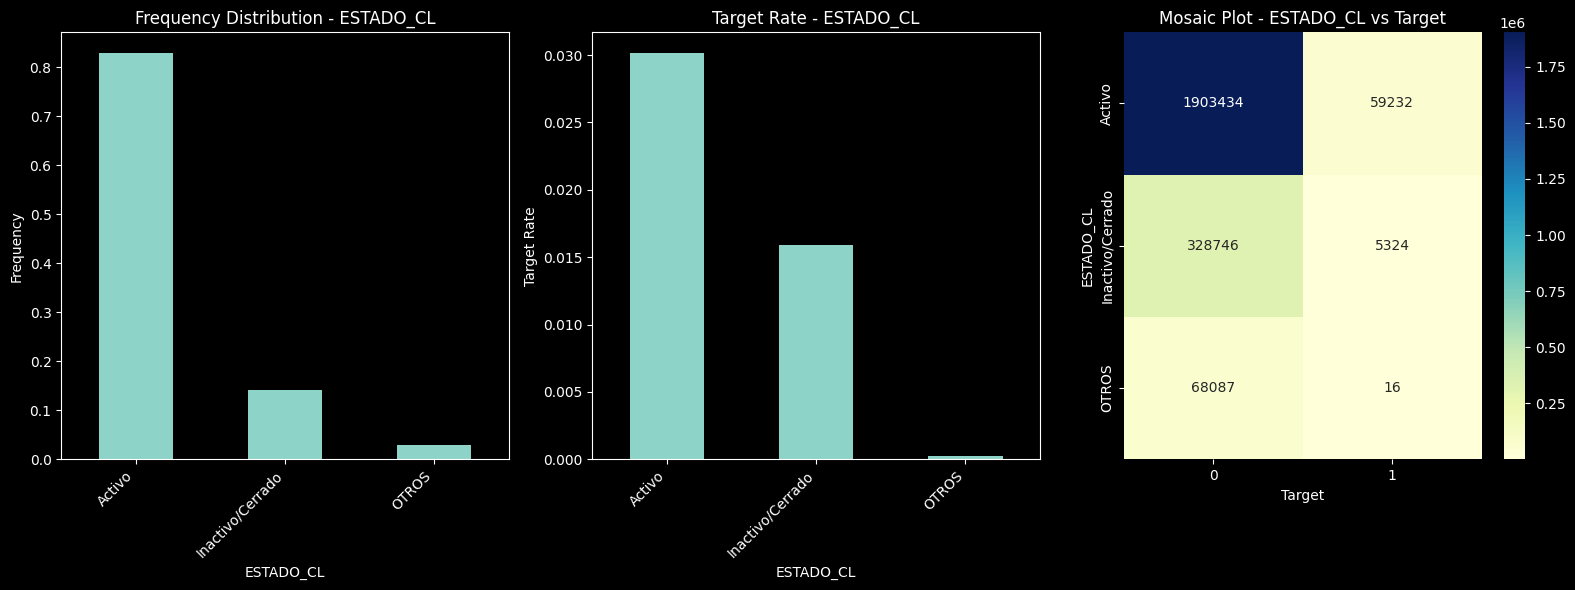

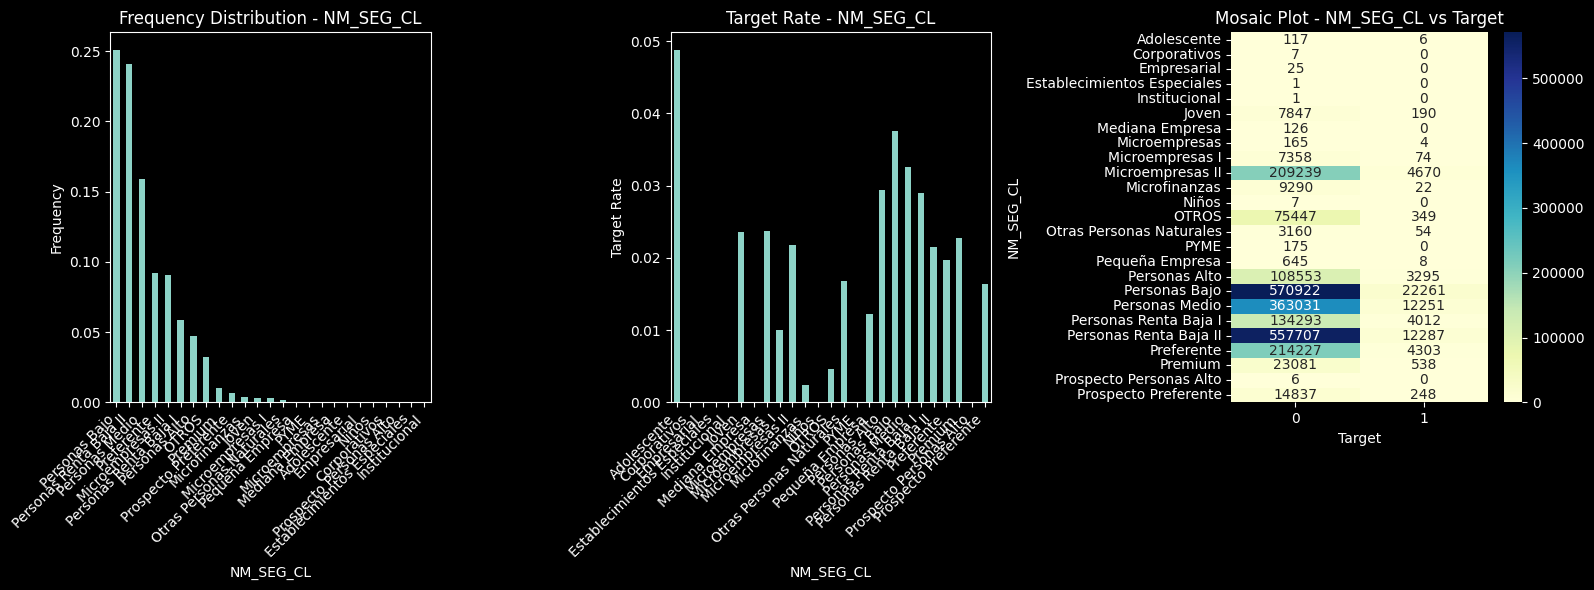

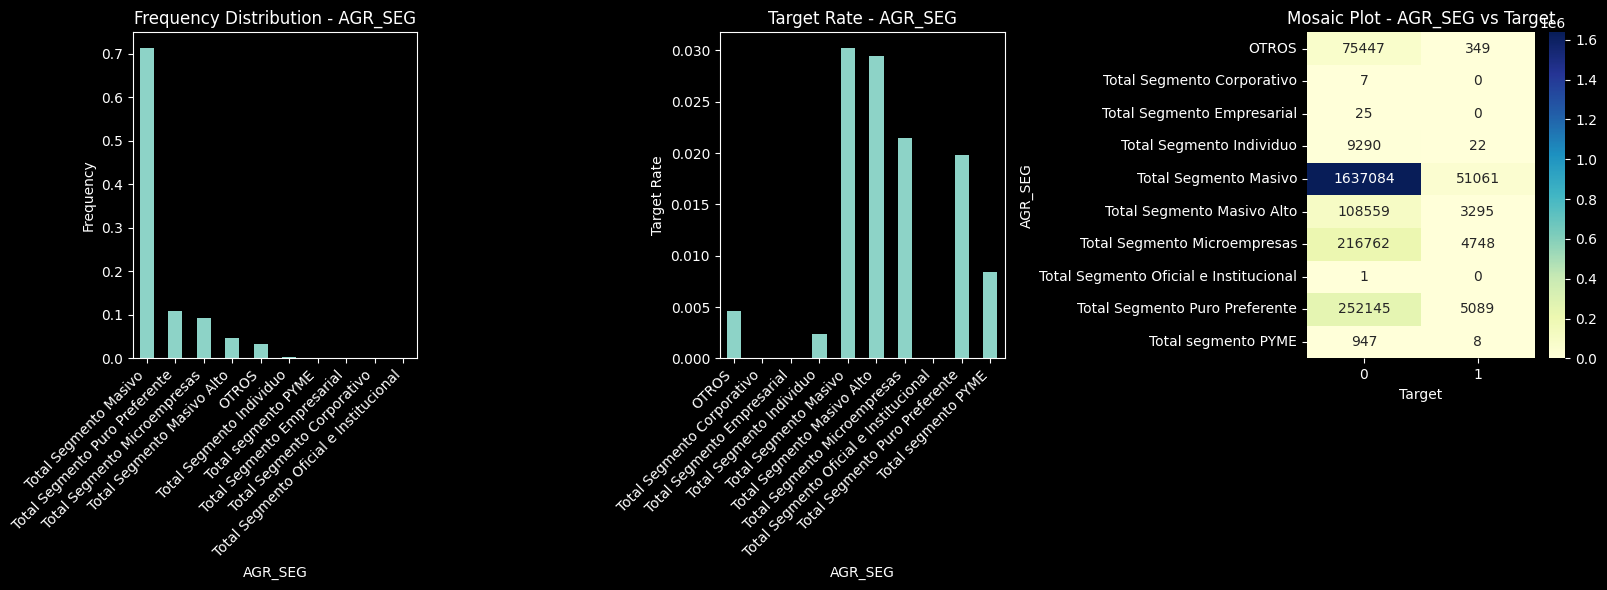

C:\Users\DF357JZ\AppData\Local\Temp\ipykernel_16736\3664280994.py:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


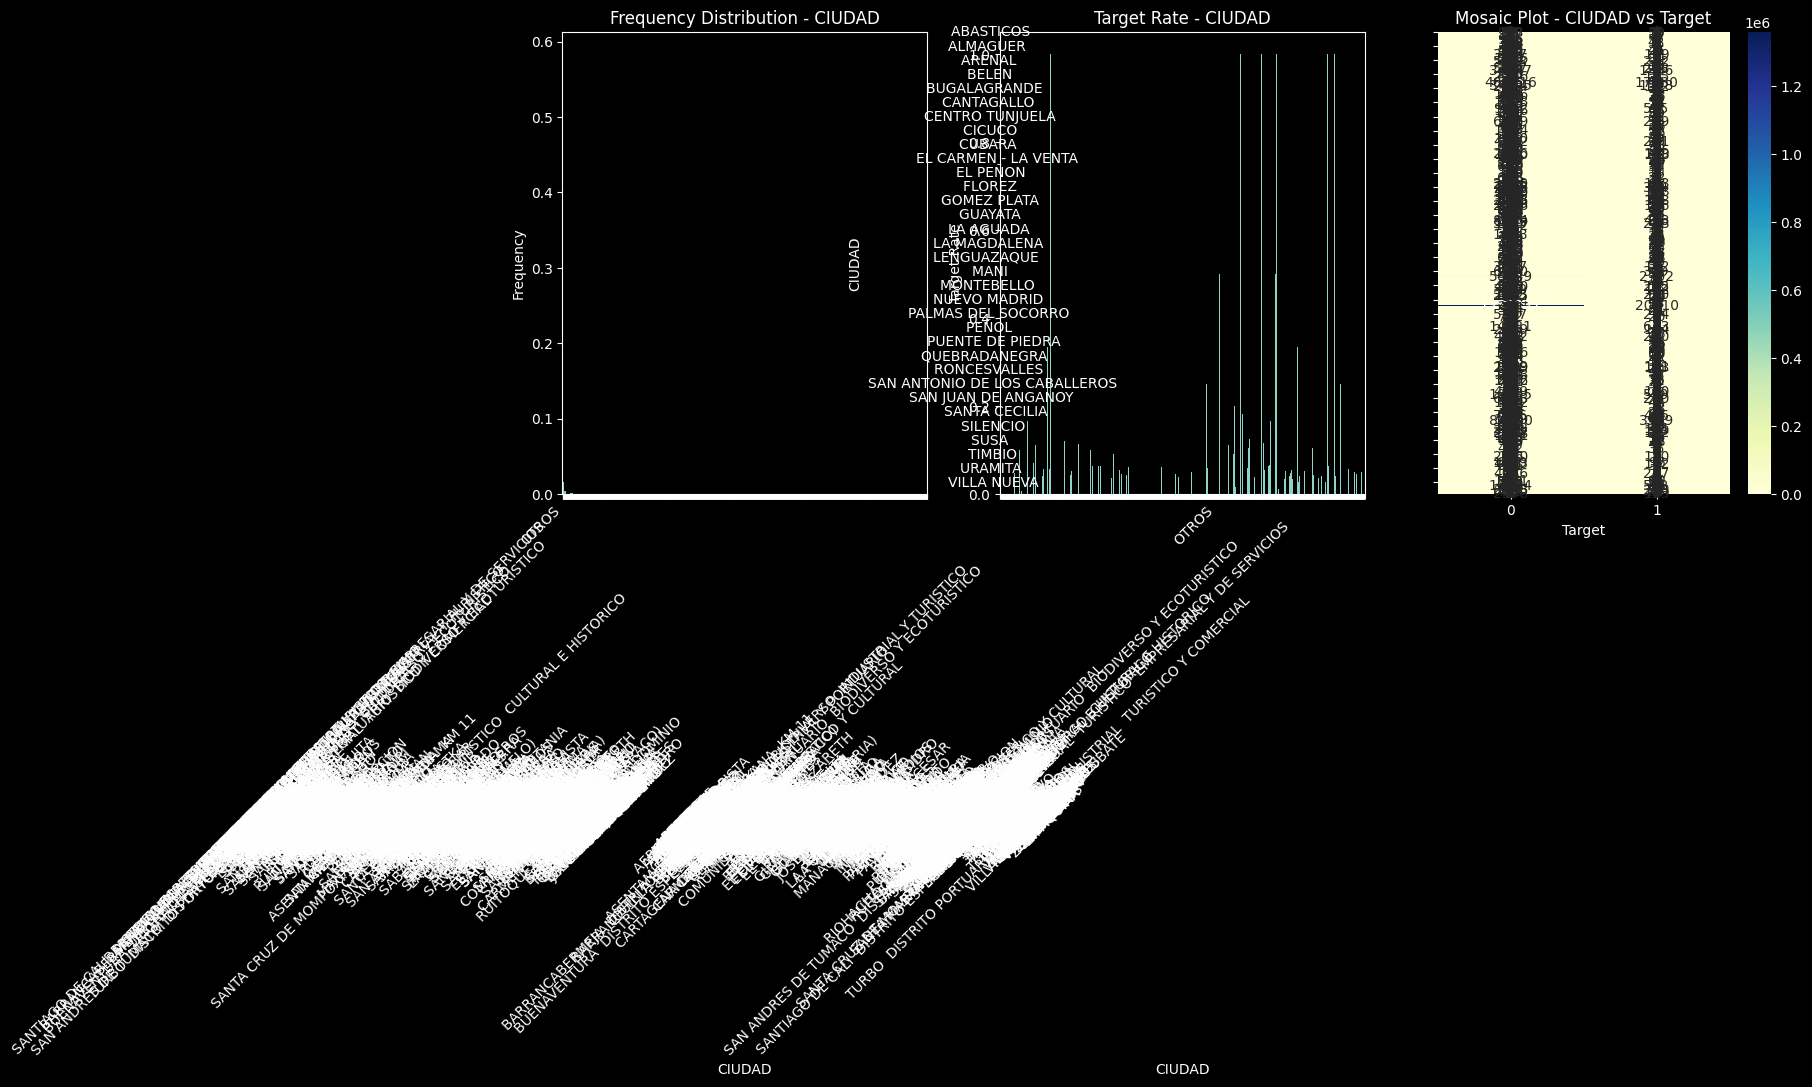

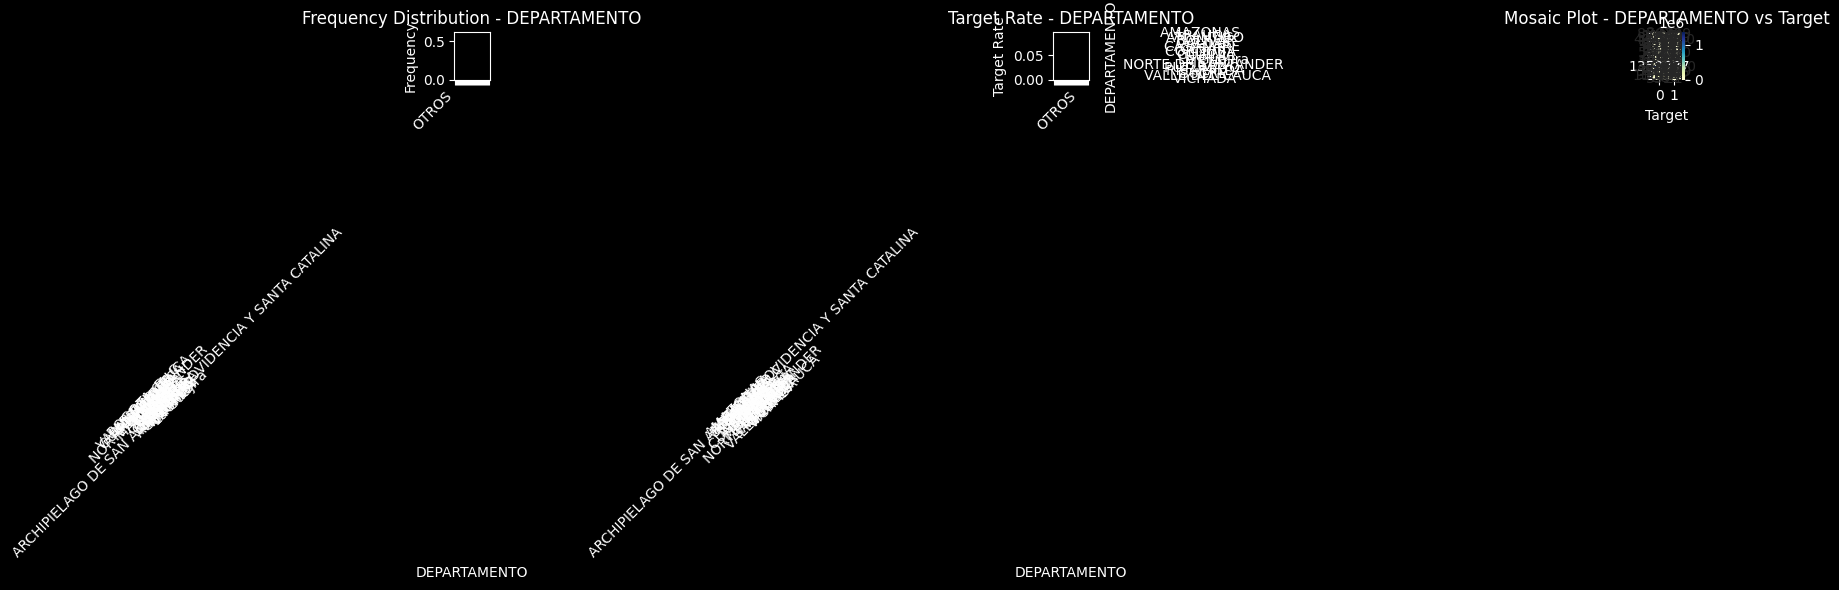

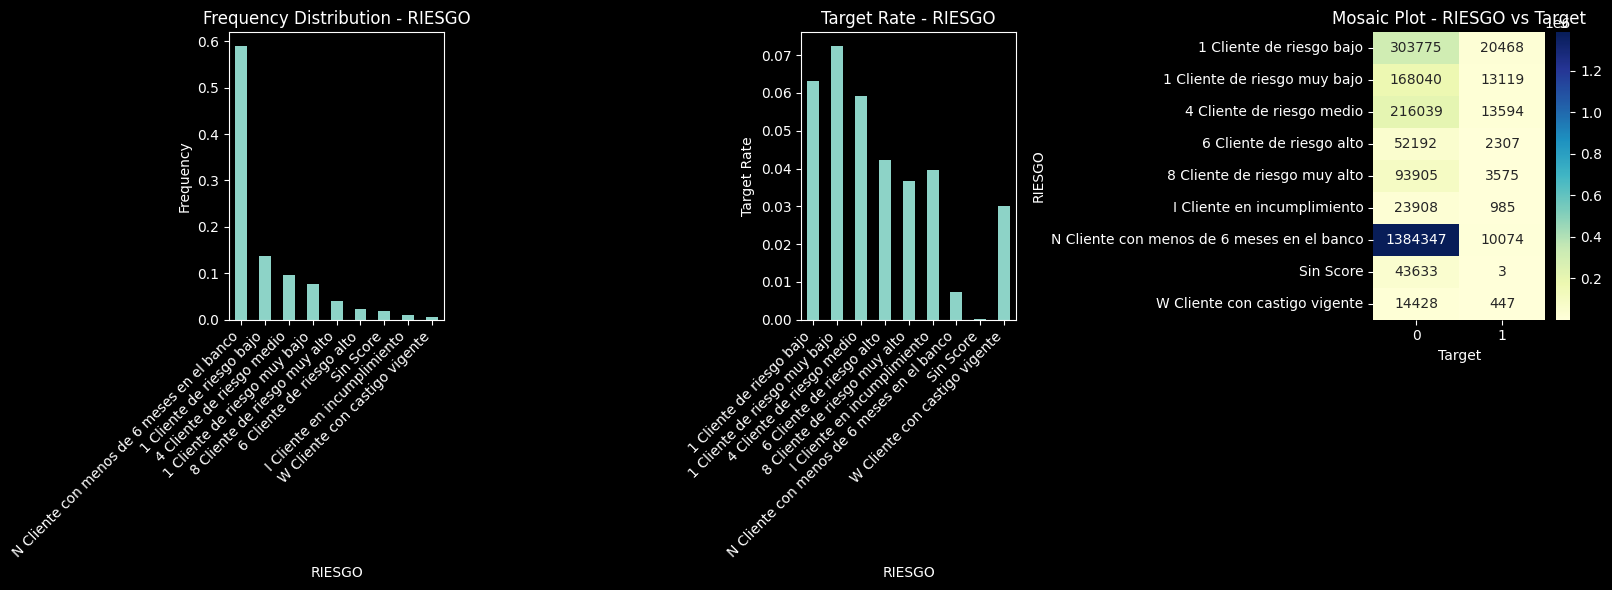

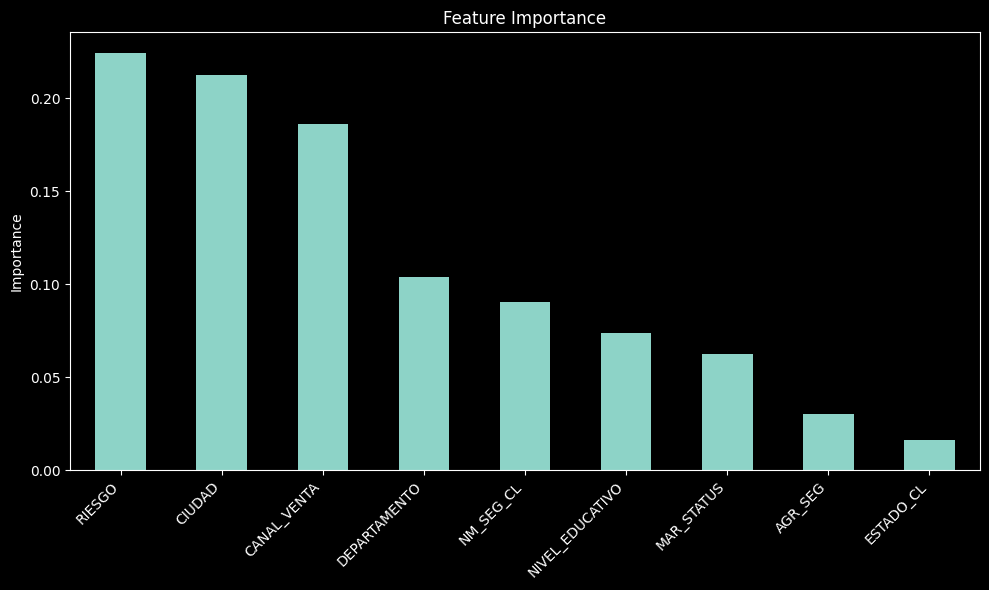

Feature Importance:
RIESGO             0.224269
CIUDAD             0.212448
CANAL_VENTA        0.186173
DEPARTAMENTO       0.104067
NM_SEG_CL          0.090512
NIVEL_EDUCATIVO    0.073733
MAR_STATUS         0.062288
AGR_SEG            0.030141
ESTADO_CL          0.016369
dtype: float64


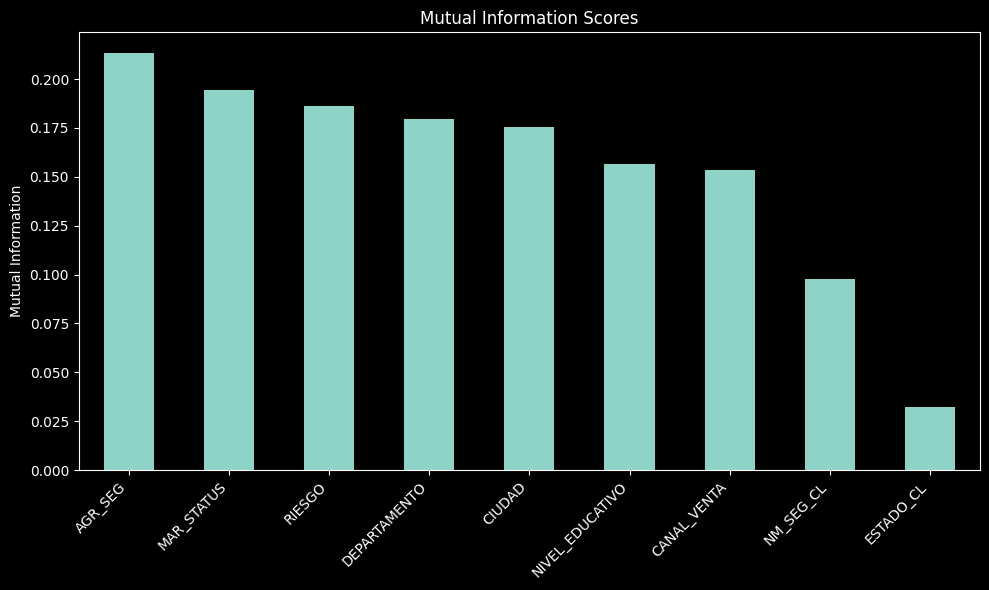


Mutual Information Scores:
AGR_SEG            0.213258
MAR_STATUS         0.194233
RIESGO             0.186267
DEPARTAMENTO       0.179696
CIUDAD             0.175597
NIVEL_EDUCATIVO    0.156777
CANAL_VENTA        0.153591
NM_SEG_CL          0.097982
ESTADO_CL          0.032457
dtype: float64


MemoryError: Unable to allocate 28.4 GiB for an array with shape (1613, 2364839) and data type float64

In [142]:
main(df.select(lista_categoricas + ['RESULTADO']).to_pandas(), 'RESULTADO')

# EXPORTAR DATASET

In [171]:
df.write_parquet(os.path.abspath(os.path.join('..')) + '\data\interim\df_camp_fs.parquet')